In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import re
sns.set_style("darkgrid")
pd.set_option('display.max_columns', None)

import matplotlib
print('matplotlib version: {}'.format(matplotlib.__version__))

import seaborn
print('seaborn version: {}'.format(seaborn.__version__))


import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")

plt.rcParams["figure.figsize"] = (6, 3)
pd.set_option("display.max_columns",None)
pd.set_option("display.max_rows",None)

matplotlib version: 3.10.1
seaborn version: 0.13.2


In [2]:
path = 'outlier_dusulmus_veri.csv'
#ri = pd.read_csv(path)  #,encoding='latin-1')
ri1=pd.read_csv(path)

In [3]:
#ri1["make_model"].value_counts()
ri1.groupby(["make", "make_model"]).size().reset_index(name="count")

,make,make_model,count
0,Dacia,Dacia Break,1
1,Dacia,Dacia Dokker,55
2,Dacia,Dacia Duster,300
3,Dacia,Dacia Jogger,9
4,Dacia,Dacia Lodgy,67
5,Dacia,Dacia Logan,195
6,Dacia,Dacia Sandero,617
7,Fiat,Fiat 124 Spider,92
8,Fiat,Fiat 500,303
9,Fiat,Fiat 500 Abarth,24


In [4]:
ri1.isna().sum()

make_model                     0
make                           0
model                          0
location                       0
price                          0
body_type                      0
type                           0
mileage                        0
gearbox                        0
paint                          0
seller                         0
power                          0
engine_size                    0
CO2_emissions                  0
empty_weight                   0
full_service_history           0
upholstery                     0
previous_owner                 0
age                            0
fuel_type                      0
cons_avg                       0
comfort_convenience_count_z    0
entertainment_media_count_z    0
safety_security_count_z        0
extras_count_z                 0
dtype: int64

In [7]:

# 1) “nan Value” metinlerini gerçek NaN’a dönüştürdüyseniz zaten fuel_type’da NaN kalmış durumda.
#    Eğer henüz yapmadıysanız:
#
ri1['fuel_type'] = ri1['fuel_type'].replace('nan Value', np.nan)

# 2) make_model bazlı mode haritasını oluştur
#    Her make_model için fuel_type’ın en sık görülen (ilk mod) değerini alıyoruz.
make_model_mode = ri1.groupby('make_model')['fuel_type'] \
                    .agg(lambda s: s.mode().iloc[0] if not s.mode().empty else np.nan)

# 3) make bazlı mode haritasını oluştur (eğer make_model’da mod yoksa kullanmak için)
make_mode = ri1.groupby('make')['fuel_type'] \
             .agg(lambda s: s.mode().iloc[0] if not s.mode().empty else np.nan)

# 4) Dataset geneli için genel mode’u bul
overall_mode = ri1['fuel_type'].mode().iloc[0]

# 5) “fuel_type” doldurma adımları:
#
#    a) Önce make_model level’da NaN olanları, kendi make_model grubunun mod’u ile doldur
ri1['fuel_type'] = ri1.apply(
    lambda row: make_model_mode[row['make_model']] 
                if pd.isna(row['fuel_type']) and pd.notna(make_model_mode[row['make_model']]) 
                else row['fuel_type'],
    axis=1
)

#    b) Hâlâ NaN kalanlara, kendi make grubunun mode’unu atayın
ri1['fuel_type'] = ri1.apply(
    lambda row: make_mode[row['make']] 
                if pd.isna(row['fuel_type']) and pd.notna(make_mode[row['make']]) 
                else row['fuel_type'],
    axis=1
)

#    c) Yine NaN kalan varsa, genel mode’u ata
ri1['fuel_type'].fillna(overall_mode, inplace=True)

# 6) Sonuçları kontrol edelim
print(ri1['fuel_type'].isna().sum())         # 0 dönecek, artık NaN kalmadı
print(ri1['fuel_type'].value_counts())       # Hangi yakıt tiplerinden kaç tane kaldığını görebilirsiniz

0
fuel_type
Petrol      15442
Diesel       8651
Gas           323
Others        269
Electric       55
Name: count, dtype: int64


In [8]:
ri1.dtypes

make_model                      object
make                            object
model                           object
location                        object
price                          float64
body_type                       object
type                            object
mileage                        float64
gearbox                         object
paint                           object
seller                          object
power                          float64
engine_size                    float64
CO2_emissions                  float64
empty_weight                   float64
full_service_history            object
upholstery                      object
previous_owner                   int64
age                            float64
fuel_type                       object
cons_avg                       float64
comfort_convenience_count_z    float64
entertainment_media_count_z    float64
safety_security_count_z        float64
extras_count_z                 float64
dtype: object

In [13]:
ri1.describe().T

,count,mean,std,min,25%,50%,75%,max
price,24740.0,22045.678173,17858.574942,1000.000000,11900.000000,17000.000000,26999.000000,200000.000000
mileage,24740.0,75567.922191,60160.091500,105.000000,26829.000000,62450.500000,109752.250000,300000.000000
power,24740.0,162.367967,85.926783,54.000000,110.000000,136.000000,190.000000,600.000000
engine_size,24740.0,1752.780861,699.246171,332.000000,1364.000000,1598.000000,1984.000000,6208.000000
CO2_emissions,24740.0,130.807842,54.832542,0.000000,104.000000,124.000000,156.000000,300.000000
empty_weight,24740.0,1422.107963,254.819953,900.000000,1273.000000,1395.000000,1536.000000,2900.000000
previous_owner,24740.0,0.705780,0.925133,0.000000,0.000000,0.000000,1.000000,14.000000
age,24740.0,6.134256,5.636948,0.000000,2.000000,4.000000,8.000000,30.000000
cons_avg,24740.0,6.234238,2.142796,1.000000,4.900000,5.650000,7.000000,15.000000
comfort_convenience_count_z,24740.0,0.038831,0.990521,-1.441825,-0.811841,-0.055860,0.826117,2.842066


In [9]:
for col in ['make', 'make_model', 'body_type', 'gearbox', 'fuel_type', 'location']:
    print(col, ":", ri1[col].nunique(), "farklı değer")
    print(ri1[col].value_counts().head(), "\n")

make : 13 farklı değer
make
Volvo            3411
Opel             2171
Mercedes-Benz    2141
Peugeot          2077
Renault          1983
Name: count, dtype: int64 

make_model : 482 farklı değer
make_model
Renault Megane    813
SEAT Leon         744
Volvo V40         740
Volvo C70         666
Opel Astra        653
Name: count, dtype: int64 

body_type : 6 farklı değer
body_type
Station wagon       4989
Off-Road/Pick-up    4688
Compact             4663
Sedan               4320
Coupe               3202
Name: count, dtype: int64 

gearbox : 3 farklı değer
gearbox
Manual            14972
Automatic          9709
Semi-automatic       59
Name: count, dtype: int64 

fuel_type : 5 farklı değer
fuel_type
Petrol      15442
Diesel       8651
Gas           323
Others        269
Electric       55
Name: count, dtype: int64 

location : 8 farklı değer
location
DE    10871
ES     5932
NL     2494
IT     2044
BE     1661
Name: count, dtype: int64 



In [10]:
# “nan Value” değerlerini gerçek NaN’a çevir
#ri1['fuel_type'] = ri1['fuel_type'].replace('nan Value', np.nan)

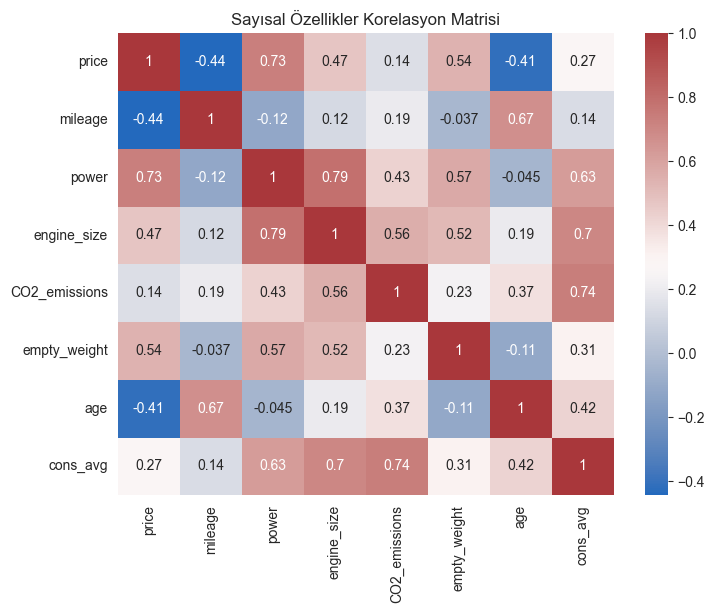

In [10]:
corr = ri1[['price','mileage','power','engine_size','CO2_emissions','empty_weight','age','cons_avg']].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='vlag')
plt.title("Sayısal Özellikler Korelasyon Matrisi")
plt.show()

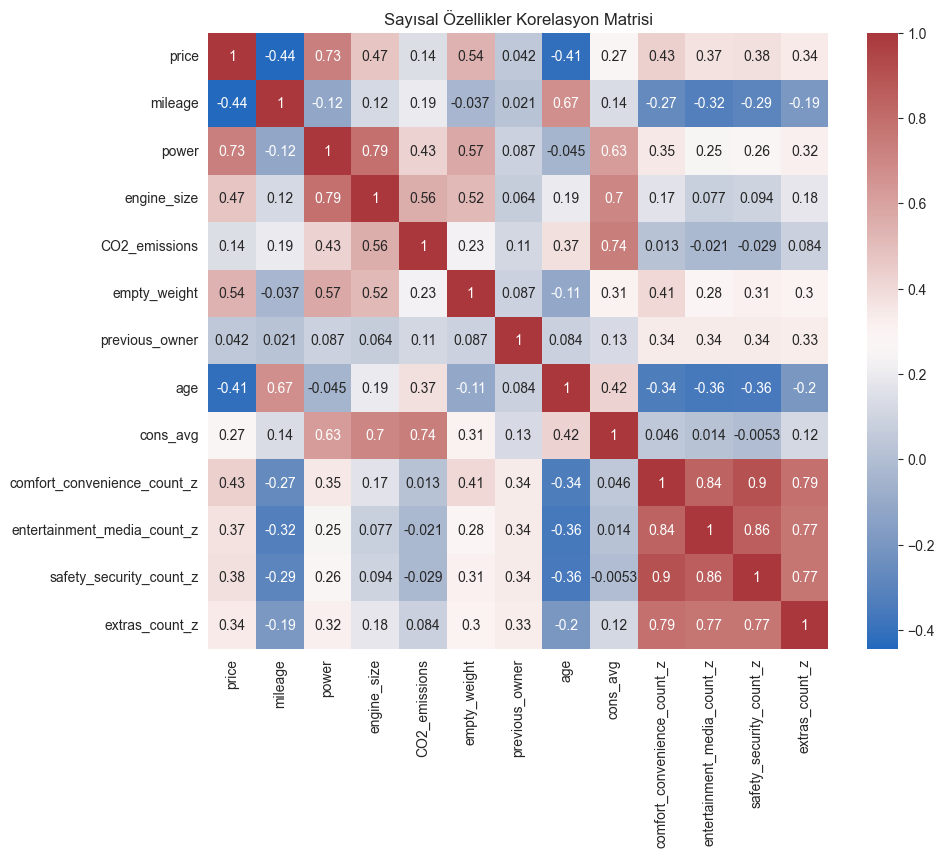

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

numeric_cols = [
    'price', 'mileage', 'power', 'engine_size', 'CO2_emissions', 'empty_weight',
    'previous_owner', 'age', 'cons_avg', 'comfort_convenience_count_z',
    'entertainment_media_count_z', 'safety_security_count_z', 'extras_count_z'
]

corr_matrix = ri1[numeric_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='vlag')
plt.title("Sayısal Özellikler Korelasyon Matrisi")
plt.show()

In [11]:

# 1) “age_times_mileage” — Yaş x Kilometre
ri1['age_times_mileage'] = ri1['age'] * ri1['mileage']

# 2) “power_per_cc” — Beygir gücü (hp) / Motor hacmi (cc)
ri1['power_per_cc'] = ri1['power'] / ri1['engine_size']
ri1['power_per_cc'] = ri1['power_per_cc'].replace([float('inf'), -float('inf')], pd.NA)

# 3) “co2_per_liter” — CO₂ emisyonu / (L/100 km → L/km)
ri1['cons_per_km']    = ri1['cons_avg'] / 100                           # L/km
ri1['co2_per_liter']  = ri1['CO2_emissions'] / ri1['cons_per_km']       # g CO₂ / L
ri1['co2_per_liter']  = ri1['co2_per_liter'].replace([float('inf'), -float('inf')], pd.NA)

# (İsteğe bağlı) Artık “cons_per_km” geçici sütununuzu silebilirsiniz:
ri1.drop(columns=['cons_per_km'], inplace=True)

# Yeni sütunları kontrol edin:
print(ri1[['age_times_mileage', 'power_per_cc', 'co2_per_liter']].head())

   age_times_mileage  power_per_cc  co2_per_liter
0                0.0      0.091275    2000.000000
1           305920.0      0.050000    2541.176471
2           305920.0      0.050000    2541.176471
3           649964.0      0.061602    2322.580645
4           249060.0      0.060000    2541.176471


In [12]:
# 1) Yaşı sıfır olan araçları seç
zero_age_cars = ri1[ri1['age'] == 0]

# 2) Kaç tane olduğunu bul
count_zero = zero_age_cars.shape[0]

# 3) Bu araçların ortalama kilometresi
mean_mileage_zero = zero_age_cars['mileage'].mean()

print(f"Yaşı sıfır olan araç sayısı: {count_zero}")
print(f"Yaşı sıfır olan araçların ortalama kilometresi: {mean_mileage_zero:.2f} km")

Yaşı sıfır olan araç sayısı: 1432
Yaşı sıfır olan araçların ortalama kilometresi: 5807.22 km


In [13]:
ri1[['age_times_mileage', 'power_per_cc', 'co2_per_liter']].isna().sum()

age_times_mileage    0
power_per_cc         0
co2_per_liter        0
dtype: int64

In [14]:
# Örneğin, yalnızca age_times_mileage tutup age ve mileage’ı çıkarabilirsiniz:
ri1.drop(columns=['age','mileage'], inplace=True)

In [15]:
# Örneğin sadece power_per_cc kalsın, power ve engine_size’ı çıkarın:
ri1.drop(columns=['power','engine_size'], inplace=True)


In [16]:
# Örneğin sadece co2_per_liter kalsın, CO2_emissions ve cons_avg’ı çıkarın:
ri1.drop(columns=['CO2_emissions','cons_avg'], inplace=True)

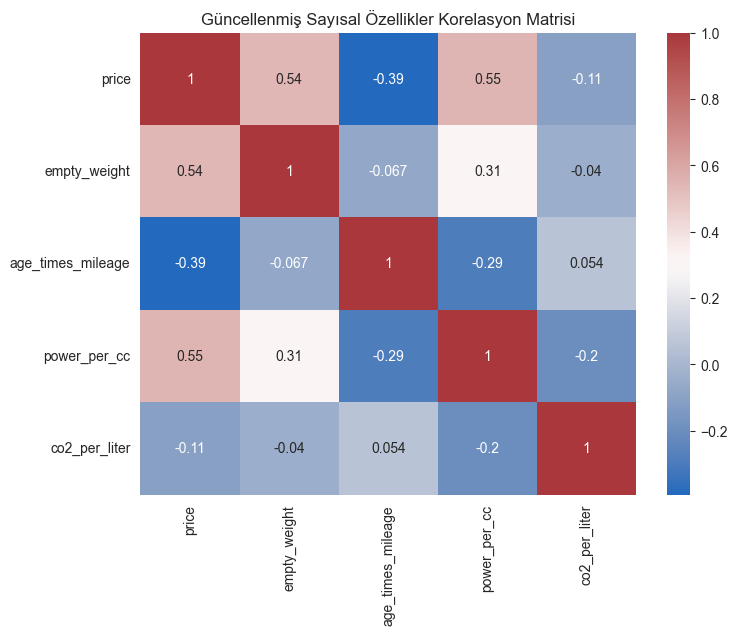

In [17]:

# 1) Korelasyon hesaplanacak yeni sayısal sütunlar
numeric_cols_new = [
    'price',
    'empty_weight',
    'age_times_mileage',
    'power_per_cc',
    'co2_per_liter'
]

# 2) Korelasyon matrisi oluştur
corr_new = ri1[numeric_cols_new].corr()

# 3) Isı haritası çizimi
plt.figure(figsize=(8, 6))
sns.heatmap(corr_new, annot=True, cmap='vlag')
plt.title("Güncellenmiş Sayısal Özellikler Korelasyon Matrisi")
plt.show()

In [18]:
ri1.columns

Index(['make_model', 'make', 'model', 'location', 'price', 'body_type', 'type',
       'gearbox', 'paint', 'seller', 'empty_weight', 'full_service_history',
       'upholstery', 'previous_owner', 'fuel_type',
       'comfort_convenience_count_z', 'entertainment_media_count_z',
       'safety_security_count_z', 'extras_count_z', 'age_times_mileage',
       'power_per_cc', 'co2_per_liter'],
      dtype='object')

📌 Sütun: make_model
   • Unique count: 482
   • First 20 values: ['Dacia Break', 'Dacia Dokker', 'Dacia Duster', 'Dacia Jogger', 'Dacia Lodgy', 'Dacia Logan', 'Dacia Sandero', 'Fiat 124 Spider', 'Fiat 500', 'Fiat 500 Abarth', 'Fiat 500C', 'Fiat 500L', 'Fiat 500X', 'Fiat 595 Abarth', 'Fiat Barchetta', 'Fiat Brava', 'Fiat Bravo', 'Fiat Coupe', 'Fiat Croma', 'Fiat Doblo'] …

--------------------------------------------------

📌 Sütun: make
   • Unique count: 13
   • Values: ['Dacia', 'Fiat', 'Ford', 'Hyundai', 'Mercedes-Benz', 'Nissan', 'Opel', 'Peugeot', 'Renault', 'SEAT', 'Skoda', 'Toyota', 'Volvo']

--------------------------------------------------

📌 Sütun: model
   • Unique count: 480
   • First 20 values: ['Break', 'Dokker', 'Duster', 'Jogger', 'Lodgy', 'Logan', 'Sandero', '124 Spider', '500', '500 Abarth', '500C', '500L', '500X', '595 Abarth', 'Barchetta', 'Brava', 'Bravo', 'Coupe', 'Croma', 'Doblo'] …

--------------------------------------------------

📌 Sütun: location
   • Uni

In [19]:
ri1['location'].value_counts()

location
DE    10871
ES     5932
NL     2494
IT     2044
BE     1661
FR     1221
AT      486
LU       31
Name: count, dtype: int64

In [20]:
# Premium kabul edilecek döşeme türleri (küçük harfe dönüştürülmüş halde)
premium_types = {'full leather', 'part leather', 'alcantara'}

# Yeni ikili sütunu oluştur:
#   - Döşeme metnini .str.lower() ile küçük harfe çevirip premium_types içinde mi diye bakıyoruz
#   - True ise 'premium', False ise 'standard' atıyoruz
ri1['upholstery_binary'] = ri1['upholstery'].str.lower().isin(premium_types).map({True: 'premium', False: 'standard'})

# Sonuç kontrolü
print(ri1[['upholstery', 'upholstery_binary']].sample(10))

         upholstery upholstery_binary
7219   Full leather           premium
9679          Cloth          standard
11253         Cloth          standard
7368   Full leather           premium
9265          Cloth          standard
11951  Full leather           premium
8832   Full leather           premium
5825          Cloth          standard
20461         Cloth          standard
18889         Cloth          standard


In [21]:
# Orijinal 'upholstery' sütununu kaldırıp, binary sütunu yeniden 'upholstery' olarak adlandıralım
ri1.drop(columns=['upholstery'], inplace=True)
ri1.rename(columns={'upholstery_binary': 'upholstery'}, inplace=True)

# Kontrol
print(ri1['upholstery'].value_counts())



upholstery
standard    14217
premium     10523
Name: count, dtype: int64


In [22]:
ri1['previous_owner'].value_counts(dropna=False)


previous_owner
0     12559
1      8346
2      2971
3       589
4       147
5        53
6        32
7        15
9        13
8        10
10        2
12        1
14        1
13        1
Name: count, dtype: int64

In [23]:
ri1 = ri1[ri1['previous_owner'] < 7].reset_index(drop=True)


In [24]:
ri1['previous_owner'].value_counts(dropna=False)


previous_owner
0    12559
1     8346
2     2971
3      589
4      147
5       53
6       32
Name: count, dtype: int64

In [42]:
# 1. Her sütun için unique değerleri ve sayısını yazdır
for col in ri1.columns:
    uniques = ri1[col].dropna().unique()  # NaN'leri dışarıda bırakmak için dropna()
    count = len(uniques)
    
    print(f"📌 Sütun: {col}")
    print(f"   • Unique count: {count}")
    
    # Eğer çok fazla benzersiz değer varsa listeyi kısaltmak için:
    if count <= 20:
        # 20’den azsa hepsini göster
        print(f"   • Values: {uniques.tolist()}")
    else:
        # 20’den fazlaysa ilk 20’sini göster
        print(f"   • First 20 values: {uniques[:20].tolist()} …")
    print("\n" + "-"*50 + "\n")

📌 Sütun: location
   • Unique count: 8
   • Values: ['BE', 'ES', 'DE', 'FR', 'IT', 'AT', 'NL', 'LU']

--------------------------------------------------

📌 Sütun: price
   • Unique count: 4426
   • First 20 values: [20500.0, 12690.0, 13475.0, 14990.0, 7200.0, 9990.0, 13680.0, 12500.0, 11980.0, 15250.0, 15700.0, 4790.0, 11930.0, 13500.0, 11990.0, 12490.0, 13900.0, 14845.0, 14500.0, 8900.0] …

--------------------------------------------------

📌 Sütun: body_type
   • Unique count: 6
   • Values: ['Station wagon', 'Compact', 'Sedan', 'Off-Road/Pick-up', 'Convertible', 'Coupe']

--------------------------------------------------

📌 Sütun: type
   • Unique count: 4
   • Values: ['Demonstration', 'Used', 'Pre-registered', "Employee's car"]

--------------------------------------------------

📌 Sütun: gearbox
   • Unique count: 2
   • Values: ['Manual', 'Automatic']

--------------------------------------------------

📌 Sütun: paint
   • Unique count: 2
   • Values: ['Non-Metallic', 'Metalic

In [25]:
# “Semi-automatic” değerlerini “Automatic” olarak güncelleyelim
ri1['gearbox'] = ri1['gearbox'].replace({'Semi-automatic': 'Automatic'})

# Değişikliği kontrol etmek için:
print(ri1['gearbox'].value_counts())

gearbox
Manual       14941
Automatic     9756
Name: count, dtype: int64


In [26]:
ri1.dtypes

make_model                      object
make                            object
model                           object
location                        object
price                          float64
body_type                       object
type                            object
gearbox                         object
paint                           object
seller                          object
empty_weight                   float64
full_service_history            object
previous_owner                   int64
fuel_type                       object
comfort_convenience_count_z    float64
entertainment_media_count_z    float64
safety_security_count_z        float64
extras_count_z                 float64
age_times_mileage              float64
power_per_cc                   float64
co2_per_liter                  float64
upholstery                      object
dtype: object

In [27]:
# 1. Her sütun için unique değerleri ve sayısını yazdır
for col in ri1.columns:
    uniques = ri1[col].dropna().unique()  # NaN'leri dışarıda bırakmak için dropna()
    count = len(uniques)
    
    print(f"📌 Sütun: {col}")
    print(f"   • Unique count: {count}")
    
    # Eğer çok fazla benzersiz değer varsa listeyi kısaltmak için:
    if count <= 20:
        # 20’den azsa hepsini göster
        print(f"   • Values: {uniques.tolist()}")
    else:
        # 20’den fazlaysa ilk 20’sini göster
        print(f"   • First 20 values: {uniques[:20].tolist()} …")
    print("\n" + "-"*50 + "\n")

📌 Sütun: make_model
   • Unique count: 482
   • First 20 values: ['Dacia Break', 'Dacia Dokker', 'Dacia Duster', 'Dacia Jogger', 'Dacia Lodgy', 'Dacia Logan', 'Dacia Sandero', 'Fiat 124 Spider', 'Fiat 500', 'Fiat 500 Abarth', 'Fiat 500C', 'Fiat 500L', 'Fiat 500X', 'Fiat 595 Abarth', 'Fiat Barchetta', 'Fiat Brava', 'Fiat Bravo', 'Fiat Coupe', 'Fiat Croma', 'Fiat Doblo'] …

--------------------------------------------------

📌 Sütun: make
   • Unique count: 13
   • Values: ['Dacia', 'Fiat', 'Ford', 'Hyundai', 'Mercedes-Benz', 'Nissan', 'Opel', 'Peugeot', 'Renault', 'SEAT', 'Skoda', 'Toyota', 'Volvo']

--------------------------------------------------

📌 Sütun: model
   • Unique count: 480
   • First 20 values: ['Break', 'Dokker', 'Duster', 'Jogger', 'Lodgy', 'Logan', 'Sandero', '124 Spider', '500', '500 Abarth', '500C', '500L', '500X', '595 Abarth', 'Barchetta', 'Brava', 'Bravo', 'Coupe', 'Croma', 'Doblo'] …

--------------------------------------------------

📌 Sütun: location
   • Uni

In [28]:
import pandas as pd

# (İsterseniz önceden index’i sıfırlayabilirsiniz, ama zorunlu değil)
ri1.reset_index(drop=True, inplace=True)

# 1) “make” sütununu one-hot encode et
ri1 = pd.get_dummies(ri1, columns=['make'], prefix='make')

# 2) “make_model” için pandas.factorize ile label-encoding
ri1['make_model_le'] = pd.factorize(ri1['make_model'])[0]

# 3) “model” ve orijinal “make_model” sütunlarını silebilirsiniz
ri1.drop(columns=['model', 'make_model'], inplace=True)

# 4) Kolonların son hali
print(ri1.columns.tolist())

['location', 'price', 'body_type', 'type', 'gearbox', 'paint', 'seller', 'empty_weight', 'full_service_history', 'previous_owner', 'fuel_type', 'comfort_convenience_count_z', 'entertainment_media_count_z', 'safety_security_count_z', 'extras_count_z', 'age_times_mileage', 'power_per_cc', 'co2_per_liter', 'upholstery', 'make_Dacia', 'make_Fiat', 'make_Ford', 'make_Hyundai', 'make_Mercedes-Benz', 'make_Nissan', 'make_Opel', 'make_Peugeot', 'make_Renault', 'make_SEAT', 'make_Skoda', 'make_Toyota', 'make_Volvo', 'make_model_le']


In [29]:


# 1) İkili (binary) kategorik sütunları 0/1’e dönüştürmek için map sözlükleri
binary_maps = {
    'gearbox': {
        'Manual': 0,
        'Automatic': 1
    },
    'paint': {
        'Non-Metallic': 0,
        'Metalic':       1
    },
    'seller': {
        'Dealer':         0,
        'Private seller': 1
    },
    'full_service_history': {
        'no':  0,
        'yes': 1
    },
    'upholstery': {
        'standard': 0,
        'premium':  1
    }
}

# Uygula
ri1.replace(binary_maps, inplace=True)

# 2) One-Hot Encoding yapılacak sütunlar
one_hot_cols = [
    'location',
    'body_type',
    'type',
    'fuel_type'
]

# One-Hot Encoding (drop_first=True ile her sütunda ilk kategori atılır)
ri1 = pd.get_dummies(
    ri1,
    columns=one_hot_cols,
    prefix=one_hot_cols,
    drop_first=True
)

# 3) “previous_owner” zaten int64; olduğu gibi bırakıyoruz

# 4) Son hali kontrol
print("Yeni sütun sayısı:", ri1.shape[1])
print("Örnek sütunlar:", ri1.columns[:20].tolist())

Yeni sütun sayısı: 48
Örnek sütunlar: ['price', 'gearbox', 'paint', 'seller', 'empty_weight', 'full_service_history', 'previous_owner', 'comfort_convenience_count_z', 'entertainment_media_count_z', 'safety_security_count_z', 'extras_count_z', 'age_times_mileage', 'power_per_cc', 'co2_per_liter', 'upholstery', 'make_Dacia', 'make_Fiat', 'make_Ford', 'make_Hyundai', 'make_Mercedes-Benz']


In [30]:

ri1.columns

Index(['price', 'gearbox', 'paint', 'seller', 'empty_weight',
       'full_service_history', 'previous_owner', 'comfort_convenience_count_z',
       'entertainment_media_count_z', 'safety_security_count_z',
       'extras_count_z', 'age_times_mileage', 'power_per_cc', 'co2_per_liter',
       'upholstery', 'make_Dacia', 'make_Fiat', 'make_Ford', 'make_Hyundai',
       'make_Mercedes-Benz', 'make_Nissan', 'make_Opel', 'make_Peugeot',
       'make_Renault', 'make_SEAT', 'make_Skoda', 'make_Toyota', 'make_Volvo',
       'make_model_le', 'location_BE', 'location_DE', 'location_ES',
       'location_FR', 'location_IT', 'location_LU', 'location_NL',
       'body_type_Convertible', 'body_type_Coupe',
       'body_type_Off-Road/Pick-up', 'body_type_Sedan',
       'body_type_Station wagon', 'type_Employee's car', 'type_Pre-registered',
       'type_Used', 'fuel_type_Electric', 'fuel_type_Gas', 'fuel_type_Others',
       'fuel_type_Petrol'],
      dtype='object')

In [38]:
ri1.sample(38)

,price,gearbox,paint,seller,empty_weight,full_service_history,previous_owner,comfort_convenience_count_z,entertainment_media_count_z,safety_security_count_z,extras_count_z,age_times_mileage,power_per_cc,co2_per_liter,upholstery,make_Dacia,make_Fiat,make_Ford,make_Hyundai,make_Mercedes-Benz,make_Nissan,make_Opel,make_Peugeot,make_Renault,make_SEAT,make_Skoda,make_Toyota,make_Volvo,make_model_le,location_BE,location_DE,location_ES,location_FR,location_IT,location_LU,location_NL,body_type_Convertible,body_type_Coupe,body_type_Off-Road/Pick-up,body_type_Sedan,body_type_Station wagon,type_Employee's car,type_Pre-registered,type_Used,fuel_type_Electric,fuel_type_Gas,fuel_type_Others,fuel_type_Petrol
14736,29995.0,1,1,0,1430.0,0,0,-0.181857,0.287837,0.644587,-0.523286,39678.0,0.136136,2384.615385,1,False,False,False,False,False,False,False,True,False,False,False,False,False,369,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,True
20799,46750.0,1,0,0,1504.0,0,0,-1.441825,-1.285381,-1.591889,-1.044769,6758.0,0.122400,0.000000,0,False,False,False,False,False,False,False,False,False,False,False,True,False,449,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True,True,False,False,False
3537,20950.0,0,1,0,1263.0,1,0,1.456101,0.025634,0.644587,0.780421,195198.0,0.080053,2583.333333,0,False,False,True,False,False,False,False,False,False,False,False,False,False,47,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False
252,25190.0,0,1,0,1406.0,1,1,0.826117,1.598852,0.520338,1.301904,0.0,0.112613,2428.571429,1,True,False,False,False,False,False,False,False,False,False,False,False,False,2,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True
15960,10345.0,0,1,0,1362.0,1,6,-0.055860,-0.236569,-0.100905,-0.262545,2615400.0,0.126126,2142.857143,0,False,False,False,False,False,False,False,False,True,False,False,False,False,389,False,False,False,False,False,False,True,False,True,False,False,False,False,False,True,False,False,False,True
15412,12900.0,0,1,0,1469.0,1,1,0.952114,1.074446,1.141582,0.780421,903000.0,0.075291,2575.000000,1,False,False,False,False,False,False,False,False,True,False,False,False,False,382,True,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False
16004,21990.0,1,0,0,1505.0,0,0,1.078111,0.287837,0.023344,0.780421,172000.0,0.126700,2110.236220,0,False,False,False,False,False,False,False,False,True,False,False,False,False,389,True,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,True
9952,20490.0,0,0,0,1379.0,0,0,-0.685844,-0.236569,-0.722148,-0.784028,94000.0,0.075291,2538.461538,0,False,False,False,False,False,True,False,False,False,False,False,False,False,300,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False
13779,12890.0,0,1,0,1160.0,0,1,-1.063835,-0.498772,-0.597900,-0.784028,295096.0,0.061875,1958.762887,0,False,False,False,False,False,False,False,True,False,False,False,False,False,351,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False
2365,38700.0,0,0,1,1310.0,0,0,-0.811841,-0.498772,-0.473651,0.258938,1471200.0,0.110110,2178.403756,1,False,True,False,False,False,False,False,False,False,False,False,False,False,17,False,False,False,False,True,False,False,False,True,False,False,False,False,False,True,False,False,False,True


In [32]:
ri1.isna().sum()


price                          0
gearbox                        0
paint                          0
seller                         0
empty_weight                   0
full_service_history           0
previous_owner                 0
comfort_convenience_count_z    0
entertainment_media_count_z    0
safety_security_count_z        0
extras_count_z                 0
age_times_mileage              0
power_per_cc                   0
co2_per_liter                  0
upholstery                     0
make_Dacia                     0
make_Fiat                      0
make_Ford                      0
make_Hyundai                   0
make_Mercedes-Benz             0
make_Nissan                    0
make_Opel                      0
make_Peugeot                   0
make_Renault                   0
make_SEAT                      0
make_Skoda                     0
make_Toyota                    0
make_Volvo                     0
make_model_le                  0
location_BE                    0
location_D

In [33]:
ri1.dtypes

price                          float64
gearbox                          int64
paint                            int64
seller                           int64
empty_weight                   float64
full_service_history             int64
previous_owner                   int64
comfort_convenience_count_z    float64
entertainment_media_count_z    float64
safety_security_count_z        float64
extras_count_z                 float64
age_times_mileage              float64
power_per_cc                   float64
co2_per_liter                  float64
upholstery                       int64
make_Dacia                        bool
make_Fiat                         bool
make_Ford                         bool
make_Hyundai                      bool
make_Mercedes-Benz                bool
make_Nissan                       bool
make_Opel                         bool
make_Peugeot                      bool
make_Renault                      bool
make_SEAT                         bool
make_Skoda               

In [37]:
ri1.shape


(24697, 48)

In [39]:
# 1) Veri çerçevesindeki Boolean tipli sütunları bul
bool_cols = ri1.select_dtypes(include='bool').columns.tolist()

# 2) Her birini int tipine dönüştür (True→1, False→0)
for col in bool_cols:
    ri1[col] = ri1[col].astype(int)

# 3) Kontrol: artık hepsi 0/1 olmalı
print(ri1[bool_cols].head(10))

   make_Dacia  make_Fiat  make_Ford  make_Hyundai  make_Mercedes-Benz  \
0           1          0          0             0                   0   
1           1          0          0             0                   0   
2           1          0          0             0                   0   
3           1          0          0             0                   0   
4           1          0          0             0                   0   
5           1          0          0             0                   0   
6           1          0          0             0                   0   
7           1          0          0             0                   0   
8           1          0          0             0                   0   
9           1          0          0             0                   0   

   make_Nissan  make_Opel  make_Peugeot  make_Renault  make_SEAT  make_Skoda  \
0            0          0             0             0          0           0   
1            0          0           

In [42]:
ri1.sample(50)

,price,gearbox,paint,seller,empty_weight,full_service_history,previous_owner,comfort_convenience_count_z,entertainment_media_count_z,safety_security_count_z,extras_count_z,age_times_mileage,power_per_cc,co2_per_liter,upholstery,make_Dacia,make_Fiat,make_Ford,make_Hyundai,make_Mercedes-Benz,make_Nissan,make_Opel,make_Peugeot,make_Renault,make_SEAT,make_Skoda,make_Toyota,make_Volvo,make_model_le,location_BE,location_DE,location_ES,location_FR,location_IT,location_LU,location_NL,body_type_Convertible,body_type_Coupe,body_type_Off-Road/Pick-up,body_type_Sedan,body_type_Station wagon,type_Employee's car,type_Pre-registered,type_Used,fuel_type_Electric,fuel_type_Gas,fuel_type_Others,fuel_type_Petrol
4400,42495.0,1,1,0,1803.0,1,1,1.834092,1.861055,1.887074,2.084129,112500.0,0.126087,2038.647343,1,0,0,1,0,0,0,0,0,0,0,0,0,0,55,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1
20244,4490.0,0,1,0,1365.0,0,0,-0.937838,-0.760975,-0.970646,-0.784028,3400000.0,0.079710,2242.424242,0,0,0,0,0,0,0,0,0,0,0,0,1,0,434,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1
19091,21990.0,0,1,0,1467.0,1,1,1.330105,2.123258,1.141582,1.823387,188320.0,0.078853,1685.950413,0,0,0,0,0,0,0,0,0,0,0,1,0,0,421,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1
21227,18950.0,1,1,0,1050.0,1,0,0.322130,-0.236569,0.644587,-0.523286,186927.0,0.067468,1680.000000,0,0,0,0,0,0,0,0,0,0,0,0,1,0,456,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1
2742,14750.0,0,0,0,1320.0,0,0,-0.685844,-0.760975,-0.225154,-0.784028,292392.0,0.075094,2545.454545,0,0,1,0,0,0,0,0,0,0,0,0,0,0,35,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
18467,8945.0,0,0,0,955.0,0,0,-0.937838,-0.760975,0.147592,-0.523286,279155.0,0.060060,2163.265306,0,0,0,0,0,0,0,0,0,0,0,1,0,0,416,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1
2671,11500.0,0,0,0,1290.0,0,0,-0.559847,-0.760975,-0.473651,-1.044769,603365.0,0.076122,2769.230769,0,0,1,0,0,0,0,0,0,0,0,0,0,0,35,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
18818,34960.0,1,1,0,1504.0,0,1,1.708095,1.074446,1.265830,1.301904,365600.0,0.095000,2806.722689,1,0,0,0,0,0,0,0,0,0,0,1,0,0,420,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
10872,23365.0,1,1,0,1345.0,1,1,1.456101,0.287837,1.762825,1.041163,27602.0,0.108128,2169.811321,1,0,0,0,0,0,0,1,0,0,0,0,0,0,314,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1
7579,61499.0,1,0,0,1454.0,1,1,1.456101,1.861055,1.514328,1.823387,24047.0,0.211452,1883.720930,1,0,0,0,0,1,0,0,0,0,0,0,0,0,139,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1


In [43]:
# İsteğe bağlı: İndeksi sıfırla
ri1.reset_index(drop=True, inplace=True)



In [44]:
# CSV’ye kaydet
ri1.to_csv("dummy_zafer_auto.csv", index=False)